# Simple conv-net for MNIST implemented in pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision

## Load and pre-process data

In [2]:
train_all = pd.read_csv('../input/train.csv')
train_all.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
class Mnist(torch.utils.data.dataset.Dataset):
    """
    Converts Kaggle's weird pixel-dataframe into pytorch-DataSet.
    Stores transformed images in memory for quick access.
    """
    
    def __init__(self, df: pd.DataFrame, transformation=None, labeled=True):
        
        self.labeled = labeled
        
        X = df.drop('label', axis=1, errors='ignore').values
        self.images = [torch.FloatTensor(X[i, :]).view(28, 28).unsqueeze(0) for i in range(len(df))]
        
        if labeled:
            self.labels = df.label.values
        
        if transformation:
            self.images = [transformation(x) for x in self.images]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        if self.labeled:
            return self.images[i], self.labels[i]
        else:
            return self.images[i]
    
    
def normalize(image: torch.Tensor):
    """ Normalize values into range [-0.5, 0.5] """
    return (image / 255) - 0.5

def un_normalize(image: torch.Tensor):
    return (image + 0.5) * 255

### Split the data into training- and validation-set

In [4]:
val_set_mask = np.random.rand(len(train_all)) < 0.2

train_ds = Mnist(train_all.loc[~val_set_mask], transformation=normalize)
val_ds   = Mnist(train_all.loc[val_set_mask], transformation=normalize)

batchsize = 256
train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batchsize, shuffle=False)

### Let's hava a look at the images from one batch

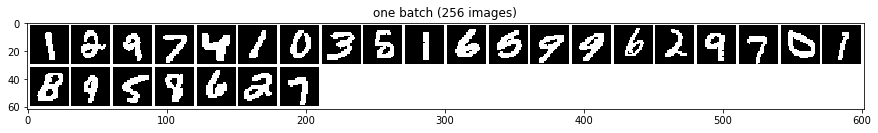

In [5]:
for i, (X, y) in enumerate(train_loader):
    pass

plt.rcParams['figure.figsize'] = [15, 15]
grid_image = un_normalize(torchvision.utils.make_grid(X, nrow=20))
plt.imshow(grid_image.permute(1, 2, 0))
plt.title(f'one batch ({batchsize} images)');

## Train Conv-net

In [6]:
def output_dim(in_dim, k=3, s=1, p=0, p_left=None, p_right=None):
    
    if p is not None:
        p_left = p_right = p
    assert p_left is not None and p_right is not None
        
    tmp = (in_dim - k + p_left + p_right) / s
    out_dim = int(np.floor(tmp) + 1)
    
    if tmp % 1 != 0:
        print('no exact output-dim; using Gauss-brackets.')
    return out_dim

#### output dimensions of convolution or pooling layers

$$W_{output} = \frac{W_{input} - F + 2*P}{S} + 1$$

with:  
W: width
F: filter width  
P: padding  
S: stride

... same goes for height

#### feature-map dimensions in this conv-net:

In [7]:
l1_dim = output_dim(in_dim=28, k=3, s=1, p=1)
print(f'after conv-layer 1: {l1_dim}')
l2_dim = output_dim(l1_dim, k=2, s=2)
print(f'after max-pooling 1: {l2_dim}')
l3_dim = output_dim(l2_dim, k=3, s=1, p=1)
print(f'\nafter conv-layer 2: {l3_dim}')
l4_dim = output_dim(l3_dim, k=2, s=2)
print(f'after max-pooling 2: {l4_dim}')
l5_dim = output_dim(l4_dim, k=3, s=1, p=1)
print(f'\nafter conv-layer 3: {l5_dim}')
l6_dim = output_dim(l5_dim, k=3, s=2)
print(f'after max-pooling 3: {l6_dim}')


after conv-layer 1: 28
after max-pooling 1: 14

after conv-layer 2: 14
after max-pooling 2: 7

after conv-layer 3: 7
after max-pooling 3: 3


Then, we have 32 channels of 3x3 feature maps, reshape those into a $32*3*3$ vector in feed it into a final fully conntected layer.

In [8]:
class SimpleConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            
            # same convolution
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # down-sample to 14**2
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            # same convolution
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # down-sample to 7**2
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            # same convolution
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # downsample to 3x3
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Linear(32 * 3**2, 10)
        # note: no softmax because it is included in cost-function
        
    def forward(self, X):
        
        features = self.features(X)
        batchsize, channels, dim, _ = features.shape
        output = self.classifier(features.view(batchsize, channels * dim**2))
        
        return output

In [9]:
net = SimpleConvNet()
net.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


error_df = pd.DataFrame(columns=['train_bce', 'train_acc', 'val_bce', 'val_acc'])  # track errors
print('\t\t|--------training---------|\t\t|-------validation--------|')
print('epoch\t\tCE\t\tAccuracy\t\tBCE\t\tAccuracy')

for epoch_i in range(50):
    
    train_bce = train_acc = 0
    
    for X, y in train_loader:
            
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        
        output = net(X)        
        loss = loss_function(output, y)
        train_bce += loss.item()
        
        # no softmax required because largest the largest value is also the largest value after softmax
        prediction = torch.max(output.data, 1)[1] 
        train_acc += (prediction == y).sum().item()
        
        # update parameters:
        loss.backward()   
        optimizer.step()
        
    val_bce = val_acc = 0
        
    for X, y in val_loader:
            
        X, y = X.cuda(), y.cuda()

        output = net(X)
        loss = loss_function(output, y)
        val_bce += loss.item()
        
        prediction = torch.max(output.data, 1)[1]
        val_acc += (prediction == y).sum().item()
    
    # convert to batch loss:
    train_bce /= len(train_loader)
    train_acc /= (len(train_loader) * batchsize)
    val_bce   /= len(val_loader)
    val_acc   /= (len(val_loader) * batchsize)
    
    error_stats = (train_bce, train_acc, val_bce, val_acc)
    error_df = error_df.append(pd.Series(error_stats, index=error_df.columns), ignore_index=True)
    print('{}\t\t{:.4f}\t\t{:.4f}\t\t\t{:.4f}\t\t{:.4f}'.format(epoch_i, *error_stats))


		|--------training---------|		|-------validation--------|
epoch		CE		Accuracy		BCE		Accuracy
0		0.8925		0.7359			0.2634		0.9214
1		0.1914		0.9355			0.1644		0.9467
2		0.1256		0.9544			0.1199		0.9605
3		0.0954		0.9631			0.0868		0.9696
4		0.0751		0.9704			0.0769		0.9737
5		0.0637		0.9737			0.0661		0.9757
6		0.0556		0.9757			0.0664		0.9783
7		0.0512		0.9776			0.0610		0.9798
8		0.0454		0.9792			0.0528		0.9827
9		0.0400		0.9803			0.0529		0.9809
10		0.0360		0.9822			0.0483		0.9841
11		0.0341		0.9825			0.0529		0.9818
12		0.0309		0.9838			0.0517		0.9821
13		0.0291		0.9835			0.0466		0.9837
14		0.0267		0.9847			0.0507		0.9832
15		0.0249		0.9855			0.0485		0.9841
16		0.0225		0.9859			0.0403		0.9854
17		0.0205		0.9867			0.0406		0.9864
18		0.0209		0.9868			0.0431		0.9865
19		0.0167		0.9884			0.0367		0.9866
20		0.0182		0.9876			0.0478		0.9843
21		0.0161		0.9882			0.0372		0.9878
22		0.0161		0.9880			0.0362		0.9876
23		0.0127		0.9892			0.0370		0.9875
24		0.0123		0.9896			0.0440		0.9865
25		0.0111		0.98

## Analyse results

In [10]:
def cout_net_parameters(net, count_shared=False):
    n_params = sum(x.numel() for x in net.parameters() if x.requires_grad)
    print(f'number of parameters: {n_params}')

    
def plot_error_curves(training_error, validation_error, error_name='error', ylim=None, save_fig=False):
    """
    @ plot training and validation-error vs. training epoch
    """
    assert len(training_error) == len(validation_error) and len(training_error) > 1
    
    fig, ax = plt.subplots()

    ax.plot(range(len(training_error)), training_error)
    ax.plot(range(len(validation_error)), validation_error)
    ax.set_xticks(range(len(training_error) + 1, len(training_error) // 2))
    
    if ylim:
        ax.set_ylim(*ylim)
    
    ax.set_xlabel('epoch')
    ax.set_ylabel('CE')
    ax.legend(('training', 'validation'))
    ax.set_title(f'{error_name} over time')
    
    if save_fig:
        fig.savefig(f'{error_name.replace(" ", "_")}_learning_curve', bbox_inches='tight', transparent=True)
    
    plt.show();
    
    
def predict_and_display(net, testset, n=10, verbose=False):
    """
    Predict @n random examples from the test-set and show images + predictions
    """
    for i in np.random.choice(range(len(testset)), size=n):
        
        X = testset[i]
        out = net(X.unsqueeze(0).cuda()).squeeze()
        pred = out.argmax().item()

        plt.figure( figsize=(2, 2) )
        plt.imshow(X.squeeze())
        plt.title(f'prediction: {pred}')
        plt.show();

### Training- and validation- error over time

number of parameters: 16938


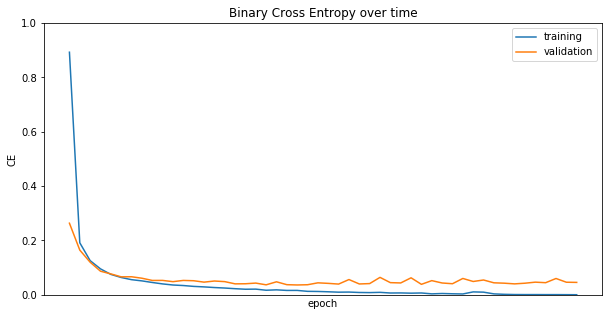

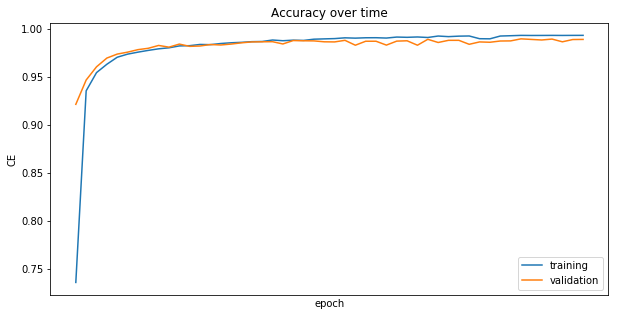

In [11]:
cout_net_parameters(net)

plt.rcParams['figure.figsize'] = [10, 5]
plot_error_curves(error_df.train_bce, error_df.val_bce, error_name='Binary Cross Entropy', ylim=(0, 1))
plot_error_curves(error_df.train_acc, error_df.val_acc, error_name='Accuracy')

### Example predictions

First, let's look at a single random example and show the output in detail.

In [12]:
test_df = pd.read_csv('../input/test.csv')
test_ds = Mnist(test_df, transformation=normalize, labeled=False)


linear layer output:
[-4.573215007781982, -31.998214721679688, -12.97119426727295, -15.763473510742188, -29.450307846069336, 0.9026708006858826, 5.580288887023926, -22.430023193359375, 25.5274715423584, -18.953950881958008]

probabilities:
[8.461312298599713e-14, 1.0397072099462646e-25, 1.906524091556518e-17, 1.168340916442867e-18, 1.3287821578727867e-24, 2.0210846884971545e-11, 2.1729464894093553e-09, 1.4870440543006194e-21, 1.0, 4.807991187873595e-20]
sum: 1.0

max probability: 1.0

prediction: 8


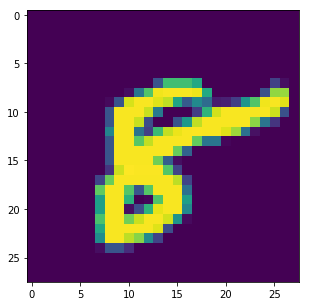

In [13]:
X = test_ds[np.random.choice(range(len(test_ds)))]
        
out = net(X.unsqueeze(0).cuda()).squeeze()
probabilities = torch.softmax(out, dim=0)
pred = probabilities.argmax().item()

print(f'\nlinear layer output:\n{out.detach().cpu().numpy().tolist()}')
print(f'\nprobabilities:\n{probabilities.detach().cpu().numpy().tolist()}')
print(f'sum: {probabilities.sum().item()}')
print(f'\nmax probability: {probabilities.max().item()}')
print(f'\nprediction: {pred}')

plt.imshow(X.squeeze());

Here are some more example predicitons:

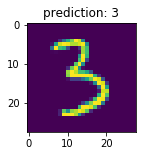

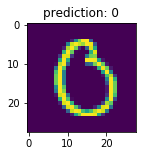

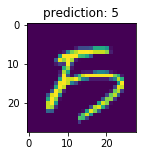

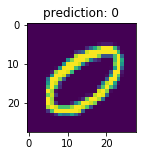

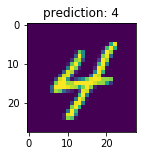

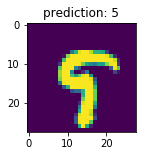

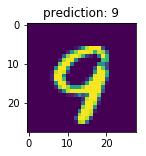

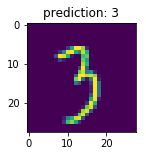

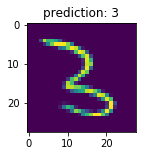

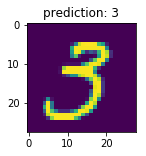

In [14]:
predict_and_display(net, test_ds, n=10)

## Create submission-file

In [15]:
test_loader = DataLoader(test_ds, batch_size=batchsize)
predictions = []
net.eval()

for X in test_loader:
    out = net(X.cuda())
    batch_predictions = torch.max(out, 1)[1]
    predictions.extend(batch_predictions.detach().cpu().numpy().tolist())

In [16]:
submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
assert len(submission_df) == len(test_df)
display(submission_df.head())

submission_df.to_csv('submission.csv', index=False)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


<a href="submission.csv"> Download submission-file </a>   
